# Set-up

This portion of the notebook is being copied over from the "satellite-data-descriptions" notebook (https://tc02d-dev.c3dti.ai/jupyter/notebooks/research_teams/gordon/exploring-data/satellite-data-descriptions.ipynb).

In [171]:
# These libraries are available in the Python 3 kernel
import pandas as pd
import numpy as np
import dill
import random
import math

# These libraries are not available in the Python 3 kernel but are in py-gordon_2_0_0
import matplotlib.pyplot as plt
import matplotlib as mpl

import cartopy.crs as ccrs

import sklearn as skl
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.gaussian_process import GaussianProcessRegressor

np.seterr(invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

In [10]:
# These are the outputs that we have available in the simulation files
variable_names = {
        "dust" : "atmosphere_optical_thickness_due_to_dust_ambient_aerosol",
        "soluble_aitken_mode" : "atmosphere_optical_thickness_due_to_soluble_aitken_mode_ambient_aerosol",
        "soluble_accumulation_mode" : "atmosphere_optical_thickness_due_to_soluble_accumulation_mode_ambient_aerosol",
        "soluble_coarse_mode" : "atmosphere_optical_thickness_due_to_soluble_coarse_mode_ambient_aerosol",
        "insoluble_aitken_mode" : "atmosphere_optical_thickness_due_to_insoluble_aitken_mode_ambient_aerosol",
        "insoluble_accumulation_mode" : "atmosphere_optical_thickness_due_to_insoluble_accumulation_mode_ambient_aerosol",
        "insoluble_coarse_mode" : "atmosphere_optical_thickness_due_to_insoluble_coarse_mode_ambient_aerosol",
}

# An array of strings "0801", "0802", ..., "0929", "0930"
dates = ["0" + str(int("0801") + k*int("0001"))
         for k in range(0, 31)] + ["0" + str(int("0901") + k*int("0001"))
                                   for k in range(0, 30)]

# Times of day in 3-hour increments, the level at which the high resolution simulations were averaged
# Of the form 'HA' or 'HP', where 'H' is the hour (a multiple of 3) and 'A' or 'P' designates AM or PM
times = ['3A', '6A', '9A', '12P', '3P', '6P', '9P', '12A']

# An array of strings "000", "001", ..., "219", "220"
ensemble = ["0"*(3-len(str(int("000") + k*int("001")))) + str(int("000") + k*int("001")) for k in range(0, 221)]

# A comma-separated table of simulation ensemble members' parameter combinations
csv_table_metric = c3.SimulationModelParameters.fetch().objs.toJson()

# Save this table instead as a pandas dataframe (221 ensemble members x 64 parameters)
dfparams = pd.DataFrame(csv_table_metric)
dfparams["member"] = dfparams.id.str.split('_', 3, expand=True)[3].apply(lambda x: x.zfill(3))
dfparams_of_interest = dfparams.iloc[:, list(range(5, 8)) + list(range(28, 65))]

We believe a priori that the inputs which start with "acure_carb_ff," "acure_carb_bb," or "acure_carb_res" are irrelevant to our analyses.

In [11]:
print(dfparams_of_interest.columns)

Index(['acure_bl_nuc', 'acure_ait_width', 'acure_cloud_ph',
       'acure_carb_ff_diam', 'acure_carb_bb_diam', 'acure_carb_res_diam',
       'acure_prim_so4_diam', 'acure_sea_spray', 'acure_anth_so2',
       'acure_anth_so2_chi', 'acure_anth_so2_asi', 'acure_anth_so2_eur',
       'acure_anth_so2_nam', 'acure_anth_so2_r', 'acure_volc_so2',
       'acure_bvoc_soa', 'acure_dms', 'acure_prim_moc', 'acure_dry_dep_ait',
       'acure_dry_dep_acc', 'acure_dry_dep_so2', 'acure_kappa_oc',
       'acure_sig_w', 'acure_rain_frac', 'acure_cloud_ice_thresh',
       'acure_convective_plume_scavenging', 'acure_scav_diam', 'acure_bc_ri',
       'acure_oxidants_oh', 'acure_oxidants_o3', 'bparam', 'two_d_fsd_factor',
       'c_r_correl', 'acure_autoconv_exp_lwp', 'acure_autoconv_exp_nd',
       'dbsdtbs_turb_0', 'ai', 'm_ci', 'a_ent_1_rp', 'member'],
      dtype='object')


# Open sample

This portion of the notebook is also copied over from "satellite-data-descriptions." These are methods specifically for opening datasets. It will be rendered useless when datasets can be obtained directly from a table.

In [12]:
def open_sat_sim(date = "0826", member = "000"):
    """
    Download netCDF file from Azure blob

    The variable atmosphere optical depth (AOD) as found in the simulated satellite data sets are indexed by the pseudo 
    level (the wavelength for which the AOD was calculated), time (which 3X-hour mark in the day when the simulated data 
    are meant to occur), latitude, and longitude.
    
    Parameters

    date : string
        day of 2017 of form "mmdd"
    member : string
        ensemble member, from "000" to "220"

    Value

    netCDF data frame
    """

    file_name = "azure://monthly-mean-simulations/bs714a.pb2017" + date + ".pp_" + member + ".nc"

    return(c3.NetCDFUtil.openFile(file_name))


def flatten_variable(df, name):
    """
    Helper function for 'select_sim_data'. Reshapes multidimensional array as one long array.

    Parameters

    df : netCDF data frame
    name : string
        the name of a variable (i.e. from variable_names)
    
    Value
    
    list
        a 1-d vector of elements in the chosen array
    """

    var = df[name][:][2, :, :, :]

    return(np.array(var).flatten())


def select_sim_data(df, member = "000"):
    """
    Unpack the netCDF file as a Pandas dataframe

    Constants

    times : list of strings
        the time periods at which the simulated data are meant to occur
    dfparams_of_interest: Pandas DataFrame

    Parameters

    df : netCDF data frame
    member : string
        ensemble member, from "000" to "220"

    Value

    Pandas DataFrame
        columns are the variables of parameter df
    """

    # We relabel longitude values so that they fall between -180 and +180, just as the data are plotted using
    # cartopy.
    lat = df["latitude"][:]
    lon = [x*(x < 180) + (x - 360)*(x >= 180) for x in df["longitude"][:]]

    # Produce a table of all time-latitude-longitude combinations in a carefully managed order! We infer from inspecting
    # df that when we use flatten_variable(df, var[1]), first we iterate through all times for fixed latitude-longitude,
    # then we iterate through the latitudes for fixed longitude, and then finally we iterate through the longitudes.
    data = pd.DataFrame()
    data["time"] = [t for t in times for n in range(0, len(lat)*len(lon))]
    data["latitude"] = [l for l in lat for n in range(0, len(lon))]*len(times)
    data["longitude"] = [l for l in lon]*len(times)*len(lat)
    data["member"] = member

    # Enter each aerosol into the data frame as a new column by flattening the 4-d arrays from df
    for var in variable_names.items():
        data[var[0]] = flatten_variable(df, var[1])

    # Now just retain the total AOD
    data["total_aod"] = data[list(variable_names.keys())].sum(axis=1).reset_index(drop=True)
    # data.drop(list(variable_names.keys()), axis='columns', inplace=True)

    # Each member comes with an associated point in the parameter space (summarized in dfparams_of_interest). Add the
    # parameter values as columns
    data = pd.merge(data,
                    dfparams_of_interest,
                    on="member",
                    how="inner")

    return(data)


def compile_output(membs=["000"], dates=["0826"], tms=["12P"], regions=[[-180, 180, -90, 90]]):
    """
    For a specified list of ensemble members, dates, times, and a latitude-longitude region, collect all the data
    obtained by select_sim_data

    Parameters

    ensem_membs : list of strings
        ensemble members to compile
    dates : list of strings
        of the form 'mmdd'
    tms : list of strings
        of the form 'HA' or 'HP', where 'H' is the hour (a multiple of 3) and 'A' or 'P' designates AM or PM
    region : list of lists of integers
        the region of the globe whose data is desired, of the form

            [<minimum longitude>, <maximum longitude>, <minimum latitude>, <maximum latitude>]

    Value

    Pandas DataFrame
        All of the data satisfying the request specified by the parameters
    """

    my_samples = [pd.DataFrame()]*len(regions)

    for memb in membs:
        for day in dates:
            for tm in tms:

                # Obtain data frame for given member, day, time combo
                dataset = open_sat_sim(date = day, member = memb)
                sample = select_sim_data(dataset, member = memb)

                for region in range(len(regions)):
                    my_region = regions[region]

                    # Subset the sample data frame accordingly
                    sub_sample = sample[
                        (sample.time == tm) &
                        (sample.longitude >= my_region[0]) &
                        (sample.longitude <= my_region[1]) &
                        (sample.latitude >= my_region[2]) &
                        (sample.latitude <= my_region[3])
                    ].copy()

                    sub_sample["member"] = memb
                    sub_sample["date"] = day

                    my_current_sample = my_samples[region]

                    my_samples[region] = my_current_sample.append(pd.DataFrame(sub_sample))

    return(my_samples)

## Example

In [13]:
# We collect ten ensemble members' data within a region
samp=compile_output(membs=ensemble[0:10],
                   dates=["0826"],
                   tms=["12P"],
                   regions=[[-45, 40, -30, 10]])

In [14]:
# We draw just the observations within a small subregion
my_region = [-1, 1, -1, 1]

my_samp = samp[0][(samp[0].longitude >= my_region[0]) &
               (samp[0].longitude <= my_region[1]) &
               (samp[0].latitude >= my_region[2]) &
               (samp[0].latitude <= my_region[3])].copy()

In [15]:
print(my_samp)

      time  latitude  longitude member      dust  soluble_aitken_mode  \
96576  12P    -0.625     0.9375    000  0.001755             0.021600   
96767  12P    -0.625    -0.9375    000  0.002183             0.023270   
96768  12P     0.625     0.9375    000  0.002004             0.023848   
96959  12P     0.625    -0.9375    000  0.002530             0.024951   
96576  12P    -0.625     0.9375    001  0.001338             0.009790   
96767  12P    -0.625    -0.9375    001  0.001601             0.010150   
96768  12P     0.625     0.9375    001  0.001412             0.014015   
96959  12P     0.625    -0.9375    001  0.001863             0.011705   
96576  12P    -0.625     0.9375    002  0.001488             0.008676   
96767  12P    -0.625    -0.9375    002  0.001639             0.008439   
96768  12P     0.625     0.9375    002  0.001598             0.008457   
96959  12P     0.625    -0.9375    002  0.002023             0.008382   
96576  12P    -0.625     0.9375    003  0.001748   

# GP methods

This portion of the notebook is also copied over from "satellite-data-descriptions." These are methods related to fitting GPs, including cross validation and automatic relevance determination procedures. It will be rendered almost entirely useless when training jobs can be sent to the C3 server.

In [176]:
def preprocess_predictors(X):
    
    from sklearn import preprocessing

    scaler = preprocessing.StandardScaler().fit(X)
    return(scaler.transform(X))


def make_test_data(X_train, random_seed=1):
    """
    Given a set of training data, return a set of data where each of the columns are permuted, creating new data within 
    the convex hull of the original set.

    Parameters

    X_train : Numpy array
        training data
    random_seed : int
        seed for Pandas' shuffling method

    Value

    Numpy array
        testing data
    """

    random.seed(random_seed)
    unshuffled_data = pd.DataFrame(X_train)
    shuffled_data = pd.DataFrame()

    for column in range(unshuffled_data.shape[1]):
        test_column = pd.DataFrame(unshuffled_data.iloc[:, column]).sample(frac=1).reset_index(drop=True)
        shuffled_data = pd.concat([shuffled_data, test_column], axis=1)

    return(np.array(shuffled_data))


def gpr_fit_vanilla(X_train, y_train, my_mean_fit, nu=0.5):
    """
    Fit a GP on the training data, centering the training response with the 'my_mean_fit' parameter. In the prediction
    method, the mean field is specified as all zeros or a fitted regression function according to its 'mean_zero'
    parameter value.

    Parameters

    X_train : Numpy array
        training data
    y_train : Numpy array
        list of training data response values
    my_mean_fit : Scikit-learn LinearRegressor
        a mean field for y_train on X_train via linear regression for centering y_train before fitting GP
    nu : numeric
        shape parameter for Matern kernel, ideally an integer multiple of 0.5

    Value

    Scikit-learn GaussianProcessRegressor
        the fitted GP
    """

    # Create kernel
    GPR_kernel = 1.0 * skl.gaussian_process.kernels.Matern(length_scale=[1.0]*X_train.shape[1],
                                                           nu=nu)

    # Define technique
    GPReg = GaussianProcessRegressor(kernel=GPR_kernel)

    centered_y_train = y_train - my_mean_fit.predict(X_train)

    # Train it
    trained_GPReg_pipe = GPReg.fit(X_train, centered_y_train)

    return(trained_GPReg_pipe)


def mean_fit_vanilla(X_train, y_train):
    """
    Compute a linear mean surface of y_train as a function of X_train and return the surface

    Parameters

    X_train : Numpy array
        training data
    y_train : Numpy array
        list of training data response values

    Value

    Scikit-learn LinearRegressor
        a mean field for y_train on X_train via linear regression for centering y_train before fitting GP
    """

    return(LinearRegression().fit(X_train, y_train))


def gpr_pred_vanilla(X_train, y_train, X_test, nu=0.5, mean_zero=False):
    """
    Obtain predictions via GPR with a mean field fit prior to fitting the GP

    Parameters

    X_train : Numpy array
        training data
    y_train : Numpy array
        list of training data response values
    X_test : Numpy array
        testing data
    nu : numeric
        shape parameter for Matern kernel, ideally an integer multiple of 0.5
    mean_zero : logical
        if False, fit a mean field using linear regression, center the training response, and add back the mean after
        predicting

    Value

    Numpy array
        list of predicted response values for points in X_test
    """

    # Fit linear mean correction for predictions
    if mean_zero is False:
        my_mean_field = mean_fit_vanilla(X_train, y_train)
    else:
        my_mean_field = mean_fit_vanilla(X_train, np.zeros(len(y_train)))

    # Fit GPR
    my_gpr = gpr_fit_vanilla(X_train, y_train, my_mean_field, nu)

    return(my_gpr.predict(X_test) + my_mean_field.predict(X_test))


# def gpr_pred_std_vanilla(X_train, y_train, X_test, nu=0.5, mean_zero=False):
    """
    Obtain covariance matrix of predictions via GPR with a mean field fit prior to fitting the GP

    Parameters

    X_train : Numpy array
        training data
    y_train : Numpy array
        list of training data response values
    X_test : Numpy array
        testing data
    nu : numeric
        shape parameter for Matern kernel, ideally an integer multiple of 0.5
    mean_zero : logical
        if False, fit a mean field using linear regression, center the training response, and add back the mean after
        predicting

    Value

    Numpy array
        covariance matrix for predictions from points in X_test
    """

    # Fit linear mean correction for predictions
    if mean_zero is False:
        my_mean_field = mean_fit_vanilla(X_train, y_train)
    else:
        my_mean_field = mean_fit_vanilla(X_train, np.zeros(len(y_train)))

    # Fit GPR
    my_gpr = gpr_fit_vanilla(X_train, y_train, my_mean_field, nu)

    return(my_gpr.predict(X_test, return_cov=True)[1])


def cv_error_vanilla(df,
                     folds=10,
                     inputs=list(dfparams_of_interest.columns),
                     output="soluble_accumulation_mode",
                     nu=0.5,
                     mean_zero=False):
    """
    Estimate the cross-validation error of a model

    Parameters

    df : Pandas DataFrame
        full data set
    folds : integer
        number of folds for cross-validation
    inputs : list
        parameters considered from the dataset for fitting the GP
    output : str
        output of interest
    nu : numeric
        shape parameter for Matern kernel, ideally an integer multiple of 0.5
    mean_zero : logical
        if False, fit a mean field using linear regression, center the training response, and add back the mean after
        predicting
    """

    # To record the test error on each fold...
    cv_error = []

    # Assign folds to the samples
    df["fold"] = [x % folds for x in random.sample(range(df.shape[0]), df.shape[0])]

    # Set aside data
    X = np.array(df[inputs])
    y = np.array(df[output])

    for fold in range(folds):

        # Train / test split
        X_train = np.array(df[(df.fold != fold)][inputs])
        y_train = np.array(df[(df.fold != fold)][output])
        X_test = np.array(df[(df.fold == fold)][inputs])
        y_test = np.array(df[(df.fold == fold)][output])

        # Obtain predictions
        y_predictions = gpr_pred_vanilla(X_train, y_train, X_test, nu, mean_zero)

        # Compute and record error
        cv_error.append(np.mean((y_predictions - y_test) ** 2))

    return(cv_error)


def ard_vanilla(fitted_gpr,
                threshold=10,
                parameter_names=list(dfparams_of_interest.columns)):
    """
    For automatic relevance determination. Obtain the fitted length scale parameters for the fitted_gpr object

    Parameters

    fitted_gpr : Scikit-learn GaussianProcessRegressor
        a fitted GP
    threshold : numeric
        cut-off point for what we consider an acceptably small length scale for the inclusion of a variable
    inputs : list
        parameters considered from the dataset for fitting the GP

    Value

    list
        parameters' length scales after fitting
    list
        list of parameters whose length scales are less than threshold
    """

    # To record the inputs' predictive relevances R_j...
    dtype = [('input', 'U35'), ('length_scale', float)]
    length_scales_and_names = []

    # Obtain the length scales from the 'fitted_gpr' parameter GP
    variable_length_scales = fitted_gpr.kernel_.get_params()['k2__length_scale']

    # To produce a dictionary of parameters and their length scales...
    variable_names = np.array(parameter_names)

    for var in range(len(variable_names)):
        length_scales_and_names.append((variable_names[var], variable_length_scales[var]))

    scored_inputs = np.array(length_scales_and_names, dtype=dtype)

    return(np.sort(scored_inputs, order='length_scale'))

## Example 1

In [48]:
# Define training and testing sets X and y
inputs=list(dfparams_of_interest.columns)
inputs=inputs[:len(inputs)-1]
X = preprocess_predictors(np.array(my_samp[inputs]))
y = np.array(my_samp["soluble_accumulation_mode"])

In [49]:
# Fit a GP
my_mean = mean_fit_vanilla(X, y)
gp = gpr_fit_vanilla(X, y, my_mean, nu=0.5)

# Printed are views of the GP kernel, initialized and trained
print(gp.kernel)
print(gp.kernel_)
print(gp.kernel_.get_params())

1**2 * Matern(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], nu=0.5)
0.00316**2 * Matern(length_scale=[0.965, 0.837, 0.907, 0.867, 0.721, 0.311, 0.554, 0.982, 1, 0.808, 1.06, 1, 0.957, 0.857, 1.01, 0.876, 0.856, 0.691, 0.907, 0.906, 0.911, 0.757, 0.968, 0.564, 0.554, 0.817, 0.723, 0.748, 1.02, 1.06, 1.04, 0.963, 0.529, 0.695, 0.888, 0.871, 0.971, 0.97, 0.92], nu=0.5)
{'k1': 0.00316**2, 'k2': Matern(length_scale=[0.965, 0.837, 0.907, 0.867, 0.721, 0.311, 0.554, 0.982, 1, 0.808, 1.06, 1, 0.957, 0.857, 1.01, 0.876, 0.856, 0.691, 0.907, 0.906, 0.911, 0.757, 0.968, 0.564, 0.554, 0.817, 0.723, 0.748, 1.02, 1.06, 1.04, 0.963, 0.529, 0.695, 0.888, 0.871, 0.971, 0.97, 0.92], nu=0.5), 'k1__constant_value': 9.999999999999997e-06, 'k1__constant_value_bounds': (1e-05, 100000.0), 'k2__length_scale': array([0.96472009, 0.83743866, 0.907433  , 0.86708508, 0.72129427,
       0.31092447, 0.55448   , 0.98217449, 1.      

(array([ 1.,  0.,  1.,  3.,  0.,  6.,  2., 10.,  9.,  7.]),
 array([0.31092447, 0.38594992, 0.46097537, 0.53600082, 0.61102627,
        0.68605172, 0.76107717, 0.83610262, 0.91112807, 0.98615353,
        1.06117898]),
 <BarContainer object of 10 artists>)

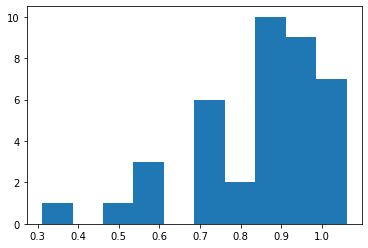

In [50]:
# We can perform automatic relevance determination with a trained model
lengths = ard_vanilla(trained_GPReg_pipe,
            threshold=10,
            parameter_names=inputs)['length_scale']
plt.hist(lengths)

## Example 2

In [57]:
# We expand the reach of our investigation, taking a larger collection of regions and obtaining samples for each
my_regions = [[19, 20, -1, 0],
              [19, 20, 0, 1],
              [20, 22, -1, 0],
              [17, 19, -1, 0],
              [19, 20, -2, -1],
              [-22, -20, -20, -19],
              [-22, -20, -19, -18],
              [-22, -20, -21, -20],
              [-24, -22, -20, -19],
              [-20, -18, -20, -19]]

my_samples = compile_output(membs=ensemble, regions=my_regions)

In [113]:
# Here are all of the inputs in the ARD-order obtained from our model in the previous example
length_scales_null = [x[0] for x in ard_vanilla(trained_GPReg_pipe, parameter_names=inputs)]
print(length_scales_null)

['acure_carb_res_diam', 'c_r_correl', 'acure_prim_so4_diam', 'acure_cloud_ice_thresh', 'acure_rain_frac', 'acure_prim_moc', 'acure_autoconv_exp_lwp', 'acure_carb_bb_diam', 'acure_scav_diam', 'acure_bc_ri', 'acure_kappa_oc', 'acure_anth_so2_chi', 'acure_convective_plume_scavenging', 'acure_ait_width', 'acure_dms', 'acure_anth_so2_r', 'acure_carb_ff_diam', 'dbsdtbs_turb_0', 'acure_bvoc_soa', 'acure_autoconv_exp_nd', 'acure_dry_dep_acc', 'acure_dry_dep_ait', 'acure_cloud_ph', 'acure_dry_dep_so2', 'a_ent_1_rp', 'acure_anth_so2_nam', 'two_d_fsd_factor', 'acure_bl_nuc', 'acure_sig_w', 'm_ci', 'ai', 'acure_sea_spray', 'acure_anth_so2', 'acure_anth_so2_eur', 'acure_volc_so2', 'acure_oxidants_oh', 'bparam', 'acure_oxidants_o3', 'acure_anth_so2_asi']


In the following cell, we obtain ARD results for all of the regions which we loaded earlier.

In [114]:
all_ard_results = pd.DataFrame()
map_data = pd.DataFrame()

def levenshteinDistance(s1, s2):
    # https://stackoverflow.com/questions/2460177/edit-distance-in-python
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

for sample in my_samples:
    
    inputs=list(dfparams_of_interest.columns)
    inputs=inputs[:len(inputs)-1]

    # Split the data
    X_train = preprocess_predictors(np.array(sample[inputs]))
    y_train = np.array(sample["total_aod"])

    my_fitted_model_mean_nonzero = gpr_fit_vanilla(X_train, y_train, mean_fit_vanilla(X_train, np.zeros(len(y_train))))

    length_scales = ard_vanilla(my_fitted_model_mean_nonzero,
                                parameter_names=inputs)
    all_ard_results = pd.concat([all_ard_results, pd.DataFrame(length_scales)], axis=1)

    my_row = {'latitude' : [np.mean(sample.latitude)],
              'longitude' : [np.mean(sample.longitude)],
              'var1' : [list(length_scales['input'])[0]],
              'var2' : [list(length_scales['input'])[1]],
              'var3' : [list(length_scales['input'])[2]],
              'var4' : [list(length_scales['input'])[3]],
              'edit_dist' : [levenshteinDistance(list(length_scales['input']),
                                                 length_scales_null)]
}
    map_data = pd.concat([map_data, pd.DataFrame(data=my_row)], axis=0)

In [115]:
print(all_ard_results.head(5))
print(map_data)

                 input  length_scale                input  length_scale  \
0       acure_anth_so2      1.000000       acure_anth_so2      1.000000   
1       acure_bvoc_soa     60.656283       acure_bvoc_soa     64.247762   
2    acure_dry_dep_acc    120.910504    acure_dry_dep_acc     89.840248   
3       acure_kappa_oc    151.451142       acure_kappa_oc    126.420134   
4  acure_prim_so4_diam    185.553856  acure_prim_so4_diam    164.467709   

               input  length_scale               input  length_scale  \
0     acure_anth_so2      1.000000      acure_anth_so2      1.000000   
1     acure_bvoc_soa     72.371997      acure_bvoc_soa     65.007315   
2  acure_dry_dep_acc    146.266663   acure_dry_dep_acc     76.016146   
3     acure_kappa_oc    166.897620      acure_kappa_oc    128.343076   
4                 ai    178.329162  acure_carb_bb_diam    315.680141   

               input  length_scale                input  length_scale  \
0     acure_anth_so2      1.000000       ac

We look at the edit distance between the ARD-resulting input lists at each region.

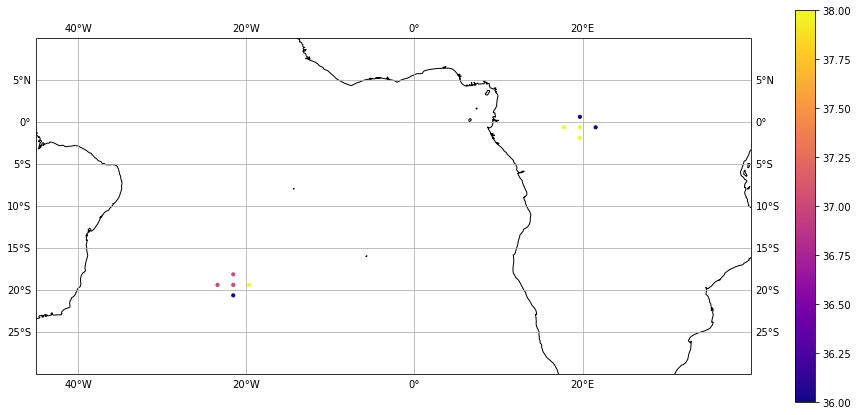

In [117]:
def plot_selected_vars(data):

    BBox = [-45, 40, -30, 10]
    
    projection = ccrs.PlateCarree(central_longitude=0)
    fig = plt.figure(figsize=[16, 12])
    
    # Draw island
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.coastlines()
    
    # Produce gridlines, coordinate labels
    ax.set_extent(BBox, ccrs.PlateCarree())
    ax.gridlines(draw_labels=True, crs=projection)

    # Add points along flight path and color for altitude
    scatter = ax.scatter(data.longitude, data.latitude, zorder=1, alpha=1,
                             c=data.edit_dist, cmap="plasma", s=10)
    cbar = plt.colorbar(scatter, shrink=0.6)

    plt.show()

plot_selected_vars(map_data)

## Example 3: Variable selection over the full region

Produce a list of all the regions so that we may perform variable selection for each pixel.

In [146]:
# Latitudes are 0.625 + k*1.25
my_lats = [0.625 + k*1.25 for k in range(-24, 7)]
# Longitudes are 0.9375 + k*1.875
my_lons = [0.9375 + k*1.875 for k in range(-24, 21)]

width = 0.1
all_regions = [[y - width, y + width, x - width, x + width] for x in my_lats[::3] for y in my_lons[::4]]

Specify the other parameters we are using -- a few different days and times of day

In [145]:
my_dates = ["0826", "0827", "0801"]
my_times = ["9A", "12P", "3P"]

inputs = list(dfparams_of_interest.columns)[:39]

### Get samples for one experiment

In this notebook, we get the results for one day and time. In copies of this notebook, results will be obtained for different days and times.

In [148]:
my_samples_full_region = compile_output(membs=ensemble,
                                    dates=[my_dates[0]],
                                    tms=[my_times[0]],
                                    regions=all_regions)

In [149]:
all_ard_results_full_region = pd.DataFrame()
map_data_full_region = pd.DataFrame()

for sample in my_samples_full_region:
    
    inputs=list(dfparams_of_interest.columns)
    inputs=inputs[:len(inputs)-1]

    # Split the data
    X_train = preprocess_predictors(np.array(sample[inputs]))
    y_train = np.array(sample["total_aod"])

    my_fitted_model_mean_nonzero = gpr_fit_vanilla(X_train, y_train, mean_fit_vanilla(X_train, np.zeros(len(y_train))))

    length_scales = ard_vanilla(my_fitted_model_mean_nonzero,
                                parameter_names=inputs)
    all_ard_results_full_region = pd.concat([all_ard_results_full_region, pd.DataFrame(length_scales)], axis=1)

    my_row = {'latitude' : [np.mean(sample.latitude)],
              'longitude' : [np.mean(sample.longitude)],
              'var1' : [list(length_scales['input'])[0]],
              'var2' : [list(length_scales['input'])[1]],
              'var3' : [list(length_scales['input'])[2]],
              'var4' : [list(length_scales['input'])[3]],
              'edit_dist' : [levenshteinDistance(list(length_scales['input'])[0:5],
                                                 ['acure_anth_so2',
                                                  'acure_sea_spray',
                                                  'acure_bvoc_soa',
                                                  'acure_dry_dep_acc',
                                                  'acure_kappa_oc'])]}
    map_data_full_region = pd.concat([map_data_full_region, pd.DataFrame(data=my_row)], axis=0)

In [152]:
print(all_ard_results_full_region)
print(map_data_full_region)

# Regeira et al 2018

                                input   length_scale  \
0                      acure_anth_so2       1.000000   
1                     acure_sea_spray      79.719433   
2                 acure_prim_so4_diam     314.529551   
3                   acure_dry_dep_acc     320.996555   
4                           acure_dms     386.348296   
5                     acure_rain_frac     450.273727   
6                          a_ent_1_rp     625.350870   
7                      dbsdtbs_turb_0     654.430059   
8                 acure_carb_res_diam    1046.294378   
9                   acure_dry_dep_ait    1091.508982   
10             acure_autoconv_exp_lwp    2476.971915   
11                 acure_anth_so2_nam   59113.741198   
12  acure_convective_plume_scavenging   93753.462796   
13                     acure_cloud_ph   95593.755781   
14                     acure_bvoc_soa   99124.215158   
15                    acure_ait_width  100000.000000   
16                 acure_anth_so2_asi  100000.00

### Functions for variable selection over full region

In [193]:
def get_selected_variables(date=my_dates[0], time=my_times[0]):
    
    my_samples_full_region = compile_output(membs=ensemble,
                                            dates=[date],
                                            tms=[time],
                                            regions=all_regions)

    map_data_full_region = pd.DataFrame()

    for sample in my_samples_full_region:

        inputs=list(dfparams_of_interest.columns)
        inputs=inputs[:len(inputs)-1]

        # Split the data
        X_train = preprocess_predictors(np.array(sample[inputs]))
        y_train = np.array(sample["total_aod"])

        my_fitted_model_mean_nonzero = gpr_fit_vanilla(X_train, y_train, mean_fit_vanilla(X_train, np.zeros(len(y_train))))

        length_scales = ard_vanilla(my_fitted_model_mean_nonzero,
                                    parameter_names=inputs)
        # all_ard_results_full_region = pd.concat([all_ard_results_full_region, pd.DataFrame(length_scales)], axis=1)

        my_row = {'latitude' : [np.mean(sample.latitude)],
                  'longitude' : [np.mean(sample.longitude)],
                  'var1' : [list(length_scales['input'])[0]],
                  'var2' : [list(length_scales['input'])[1]],
                  'var3' : [list(length_scales['input'])[2]],
                  'var4' : [list(length_scales['input'])[3]]}
        map_data_full_region = pd.concat([map_data_full_region, pd.DataFrame(data=my_row)], axis=0)
    
    return(map_data_full_region)

In [194]:
def plot_my_top_variable(data_set=my_data, variable='var2'):

    levels, categories = pd.factorize(data_set[variable])
    colors = [plt.cm.tab10(i) for i in levels]
    handles = [mpl.patches.Patch(color=plt.cm.tab10(i), label=c) for i, c in enumerate(categories)]

    projection = ccrs.PlateCarree(central_longitude=0)
    fig = plt.figure(figsize=[16, 12])

    # Draw island
    ax = fig.add_subplot(1, 1, 1, projection=projection)
    ax.coastlines()

    BBox = [-45, 40, -30, 10]
    # Produce gridlines, coordinate labels
    ax.set_extent(BBox, ccrs.PlateCarree())
    ax.gridlines(draw_labels=True, crs=projection)

    plt.scatter(data_set.longitude, data_set.latitude, c=colors)
    plt.legend(handles=handles, title='Second variable')

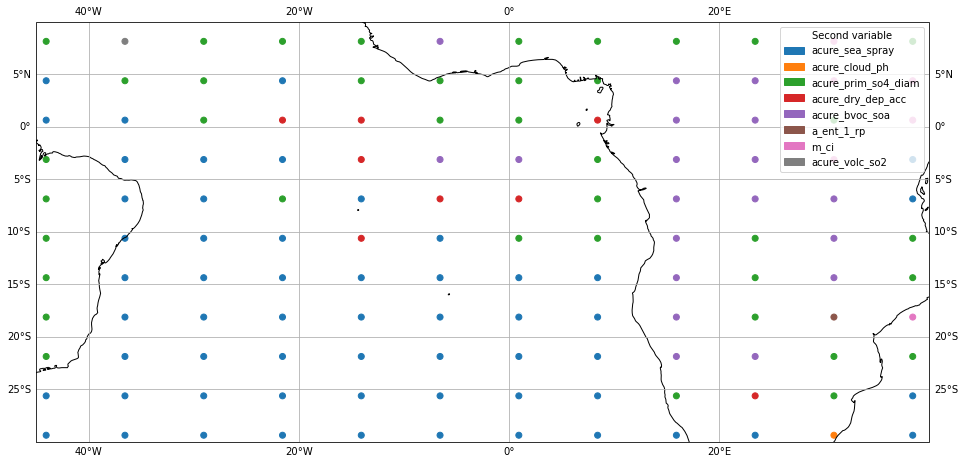

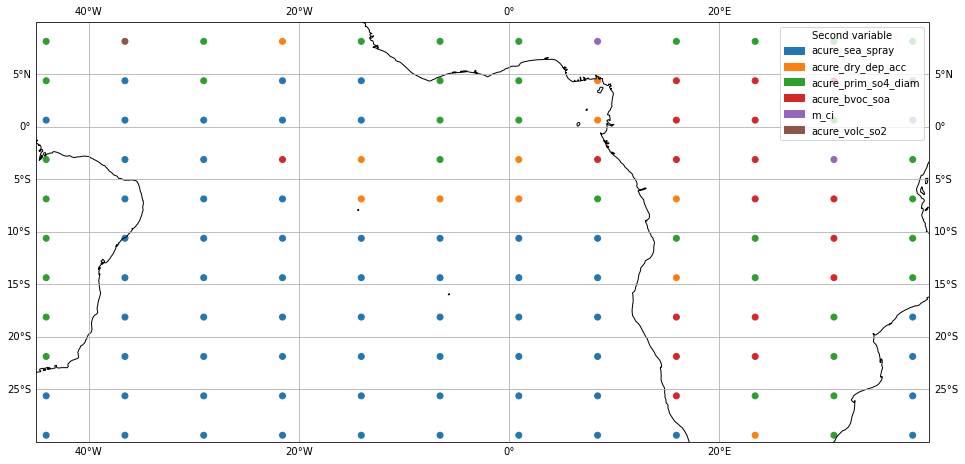

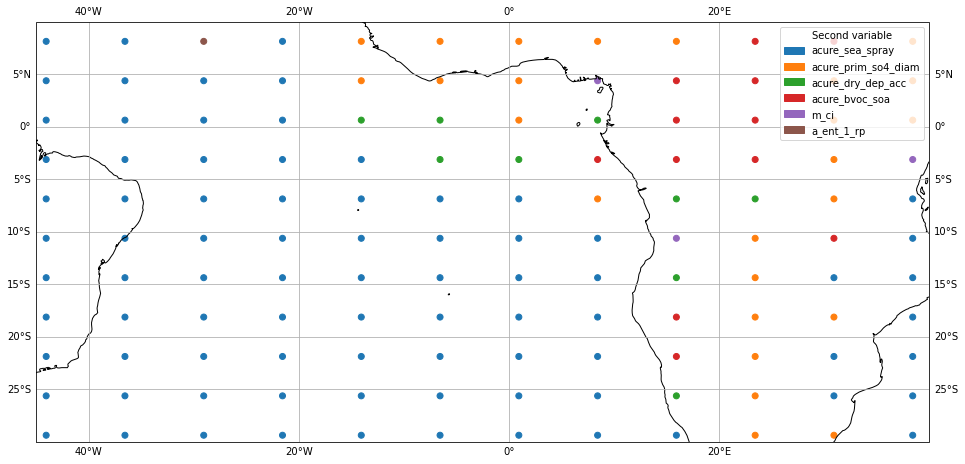

In [197]:
my_data = []

for date in my_dates:
    my_data.append(get_selected_variables(date=date))
    plot_my_top_variable(my_data[len(my_data)-1])

In [199]:
print(my_data[0])

    latitude  longitude            var1                 var2  \
0    -29.375   -44.0625  acure_anth_so2      acure_sea_spray   
0    -29.375   -36.5625  acure_anth_so2      acure_sea_spray   
0    -29.375   -29.0625  acure_anth_so2      acure_sea_spray   
0    -29.375   -21.5625  acure_anth_so2      acure_sea_spray   
0    -29.375   -14.0625  acure_anth_so2      acure_sea_spray   
..       ...        ...             ...                  ...   
0      8.125     8.4375  acure_anth_so2  acure_prim_so4_diam   
0      8.125    15.9375  acure_anth_so2  acure_prim_so4_diam   
0      8.125    23.4375  acure_anth_so2  acure_prim_so4_diam   
0      8.125    30.9375  acure_anth_so2                 m_ci   
0      8.125    38.4375  acure_anth_so2  acure_prim_so4_diam   

                   var3                var4  
0   acure_prim_so4_diam   acure_dry_dep_acc  
0     acure_dry_dep_acc      acure_volc_so2  
0     acure_dry_dep_acc                m_ci  
0   acure_prim_so4_diam   acure_dry_dep_acc  
0